# Analiza podatkov

V svoji projektni nalogi sem analiziral karte iz vsakega pomembnejšega seta [*Magic: the Gathering*](https://mtg.fandom.com/wiki/Magic:_The_Gathering?so=search). Glavnino podatkov sem zajel s strani [MTGStocks.com](https://www.mtgstocks.com/sets), saj so dobro dostopni in bolj popolni kot na evropski spletni strani. Na njej je mogoče razbrati tudi povprečno evropsko ceno kart. S strani [Scryfall.com](https://scryfall.com/sets) sem pridobil natančnejše podatke o setih. 

Pred analizo podatkov sem si zadal naslednja vprašanja:
1. Ali obstaja povezava med redkostjo in ceno kart?
2. Ali obstaja povezava med starostjo in ceno kart?
3. Kateri tipi kart so najbolj vredni?
4. Kateri seti so najbolj vredni?
5. Koliko časa od izida karte v povprečju dosežejo najnižjo ceno?
6. Kakšne so razlike med ameriškim in evropskim trgom?
7. Ali se da z naivnim Bayesovim klasifikatorjem ugotoviti barvo karte glede na oracle text?

Ker so me zanimali podatki tako ameriškega kot evropskega trga, sem večino grafov namenil obema.

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from vzorci_in_pomozne_definicije import FILENAME_POPOLNI_PODATKI_KARTE_JSON, pretvori_datum_v_datetime

In [2]:
podatkovna_baza = pd.read_json(FILENAME_POPOLNI_PODATKI_KARTE_JSON)

## Analiza kart glede na redkost

Za ogrevanje sem si ogledal deleže kart po redkosti. Radovednega bralca bi ob tem opomnil, da so štiri osnovne redkosti kart navedene v spodnji tabeli.

| redkost | prevod |
| --- | --- |
| *Common* | pogosta | 
| *Uncommon* | nepogosta | 
| *Rare* | redka |
| *Mythic* | mitična |

*Special* in *Player Rewards* karte so podeljene na posebnih dogodkih.

<AxesSubplot: title={'center': 'Deleži redkosti kart'}>

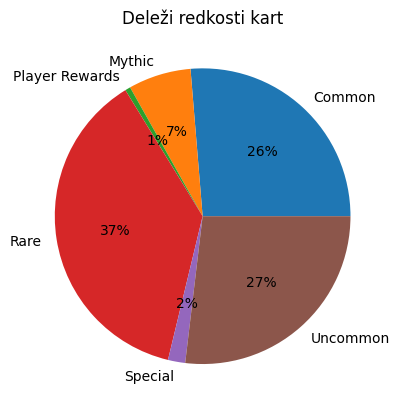

In [3]:
delezi_redkosti = podatkovna_baza.groupby("redkost").size()
delezi_redkosti.plot(kind="pie", autopct='%1.0f%%', title="Deleži redkosti kart")

Eno izmed glavnih raziskovalnih vprašanj se je navezovalo na povezavo med redkostjo in ceno kart. Zelo hitro sem ugotovil, da povprečje ne bo dobro merilo, saj so nekatere starejše karte močno zaželene pri zbirateljih in imajo posledično zelo visoko vrednost. Zato sem poleg povprečja izračunal še mediano ter povprečji z odstranjenimi robnimi primeri.

Na spodnjih dveh grafih bo komu morda presenetljivo dejstvo, da so v povprečju *Rare* karte najdražje (čeprav so okoli 6-krat pogostejše od *Mythic*-ov). Razlog je preprost: *Mythic* karte obstajajo šele od leta 2008, zato so najdražje karte praktično vse *Rare*. 

Iz grafov je razvidno, da so ameriške karte v povprečju občutno dražje, mediana njihovih cen je dosti bolj prevzdignjena. Hkrati pa so cenovna razmerja pri ameriških in evropskih kartah zelo podobna, kar razberemo iz podobne oblike grafov.

Text(0, 0.5, 'ameriška cena ($)')

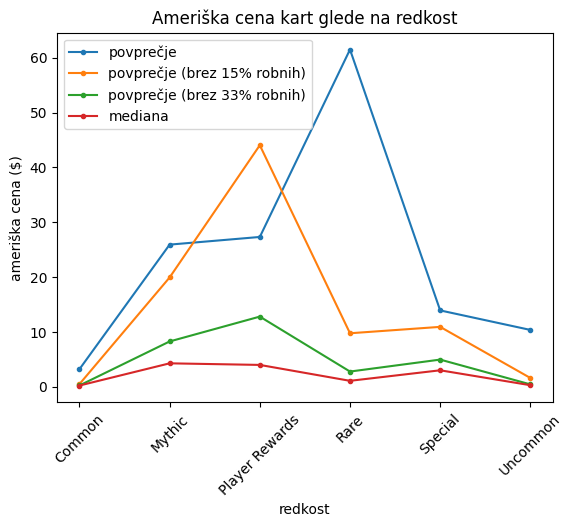

In [4]:
def q67(x):
    return x.quantile(0.67)

def q85(x):
    return x.quantile(0.85)

povprecna_cena_glede_na_redkost = podatkovna_baza.groupby("redkost")["povprecna_cena"].mean()
mediana_cena_glede_na_redkost = podatkovna_baza.groupby("redkost")["povprecna_cena"].median()   
povprecna_cena_glede_na_redkost_85 = podatkovna_baza.groupby("redkost").agg({'povprecna_cena': q85})["povprecna_cena"]
povprecna_cena_glede_na_redkost_67 = podatkovna_baza.groupby("redkost").agg({'povprecna_cena': q67})["povprecna_cena"]

df = pd.DataFrame({'povprečje': povprecna_cena_glede_na_redkost,
                   'povprečje (brez 15% robnih)': povprecna_cena_glede_na_redkost_85,
                   'povprečje (brez 33% robnih)': povprecna_cena_glede_na_redkost_67,
                   'mediana': mediana_cena_glede_na_redkost}, index=None)

ax = df.plot(rot=45, title = "Ameriška cena kart glede na redkost", style='.-')
ax.set_ylabel("ameriška cena ($)")

Text(0, 0.5, 'evropska cena (€)')

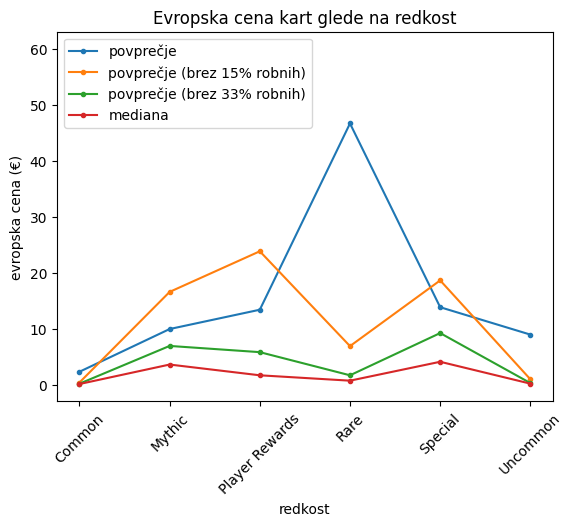

In [5]:
povprecna_cena_glede_na_redkost_eu = podatkovna_baza.groupby("redkost")["povprecje_eu"].mean()
mediana_cena_glede_na_redkost_eu = podatkovna_baza.groupby("redkost")["povprecje_eu"].median()   
povprecna_cena_glede_na_redkost_85_eu = podatkovna_baza.groupby("redkost").agg({'povprecje_eu': q85})["povprecje_eu"]
povprecna_cena_glede_na_redkost_67_eu = podatkovna_baza.groupby("redkost").agg({'povprecje_eu': q67})["povprecje_eu"]

df = pd.DataFrame({'povprečje': povprecna_cena_glede_na_redkost_eu,
                   'povprečje (brez 15% robnih)': povprecna_cena_glede_na_redkost_85_eu,
                   'povprečje (brez 33% robnih)': povprecna_cena_glede_na_redkost_67_eu,
                   'mediana': mediana_cena_glede_na_redkost_eu}, index=None)

ax = df.plot(rot=45, title = "Evropska cena kart glede na redkost", style='.-', ylim=(-3, 63))
ax.set_ylabel("evropska cena (€)")

## Analiza tipov kart

Poleg cene in redkosti so me zanimali tudi podatki o tipih [(*type*)](https://mtg.fandom.com/wiki/Card_type) in podtipih [(*subtype*)](https://mtg.fandom.com/wiki/Subtype) kart. Za lažje razumevanje je spodaj tabela osnovnih tipov z AI-generiranimi prevodi.

| MTG Cardtype | Prevod | 
|---------------|-------------|
| Creature      | Ustvarjalec | 
| Artifact      | Umetnina    | 
| Enchantment   | Očarovanje  | 
| Sorcery       | Čarovnija   | 
| Instant       | Nenadno     | 
| Land          | Krajina     | 
| Planeswalker  | Preletovalec |

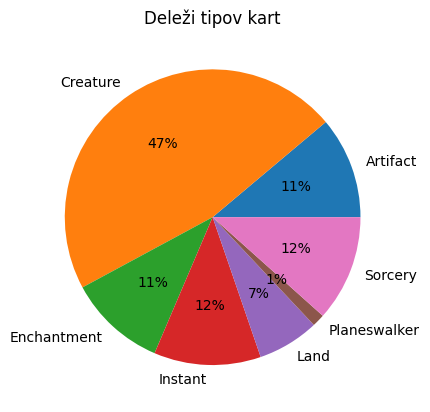

In [6]:
povezovalna_cardtype = pd.read_csv(os.path.join("Podatki", "Povezovalne_tabele", f"povezovalna_cardtype.csv"))
grupa_po_cardtypu = povezovalna_cardtype.groupby("cardtype")
velikost_grupe_po_cardtypu = grupa_po_cardtypu.size()
velikost_grupe_po_cardtypu[velikost_grupe_po_cardtypu > 100].plot.pie(title='Deleži tipov kart', autopct='%1.0f%%')
dovolj_veliki_kljuci_cardtypov = velikost_grupe_po_cardtypu[velikost_grupe_po_cardtypu > 100].keys()


Najpogostejši tip kart je nepresenetljivo *Creature*, ki predstavlja bitja, s katerimi igralec skuša pokončati nasprotnika. *Creature*-ji imajo tudi najbolj raznovrstne podtipe, kar je razvidno s spodnjega stolpičnega diagrama. Med njimi je z naskokom najpogostejši podtip *Human*. Bolj podrobno se v analizo podtipov nisem spuščal.

<AxesSubplot: title={'center': 'Najpogostejši podtipi Creature kart'}, xlabel='podtip', ylabel='število kart'>

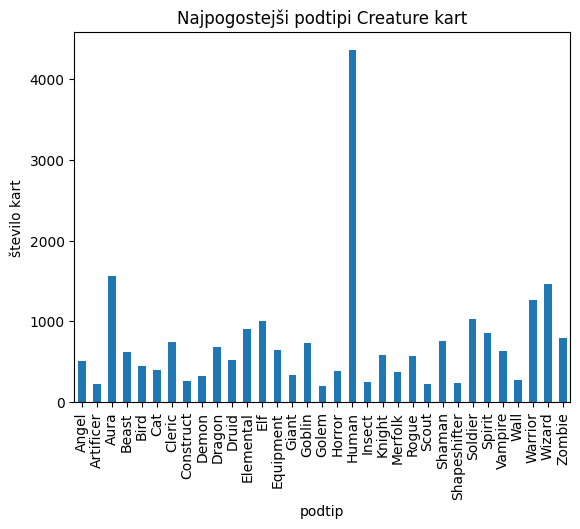

In [7]:
povezovalna_subtype = pd.read_csv(os.path.join("Podatki", "Povezovalne_tabele", "povezovalna_subtype.csv"))
grupa_po_subtypu = povezovalna_subtype.groupby("subtype")
velikost_grupe_po_subtypu = grupa_po_subtypu.size()
velikost_grupe_po_subtypu[velikost_grupe_po_subtypu > 200].plot.bar(title='Najpogostejši podtipi Creature kart', xlabel = "podtip", ylabel="število kart")

Na spodnjem grafu se lepo vidi, kako majhno število kart po ceni močno odstopa od povprečja. Če gledamo povprečje vseh kart, opazimo, da so najdražje karte *Artifact*-i in *Land*-i. Če pa robne podatke zanemarimo, prvo mesto zavzamejo *Planeswalker*-ji, za petami pa jim zopet sledijo *Land*-i.

Text(0, 0.5, 'ameriška cena ($)')

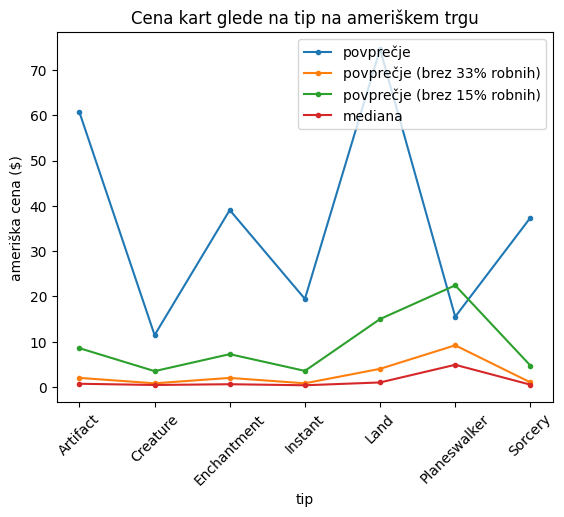

In [8]:
tabela_povprecnih_cen = podatkovna_baza[["id_karte", "povprecna_cena"]].merge(povezovalna_cardtype)
povprecna_cena = tabela_povprecnih_cen.groupby("cardtype")["povprecna_cena"].mean()[dovolj_veliki_kljuci_cardtypov]
povprecna_cena_67 = tabela_povprecnih_cen.groupby("cardtype").agg({'povprecna_cena': q67}).loc[dovolj_veliki_kljuci_cardtypov]["povprecna_cena"]
povprecna_cena_85 = tabela_povprecnih_cen.groupby("cardtype").agg({'povprecna_cena': q85}).loc[dovolj_veliki_kljuci_cardtypov]["povprecna_cena"]
mediana = tabela_povprecnih_cen.groupby("cardtype")["povprecna_cena"].median()[dovolj_veliki_kljuci_cardtypov]

df = pd.DataFrame({'povprečje': povprecna_cena,
                   'povprečje (brez 33% robnih)': povprecna_cena_67,
                   'povprečje (brez 15% robnih)': povprecna_cena_85,
                   'mediana': mediana}, index=dovolj_veliki_kljuci_cardtypov)

ax = df.plot(rot=45, title="Cena kart glede na tip na ameriškem trgu", xlabel = "tip", style='.-')
ax.set_ylabel("ameriška cena ($)")

Zanimivo je, da je graf za evropski trg praktično identičen, le da je nekoliko skrčen v navpični smeri.

Text(0, 0.5, 'evropska cena (€)')

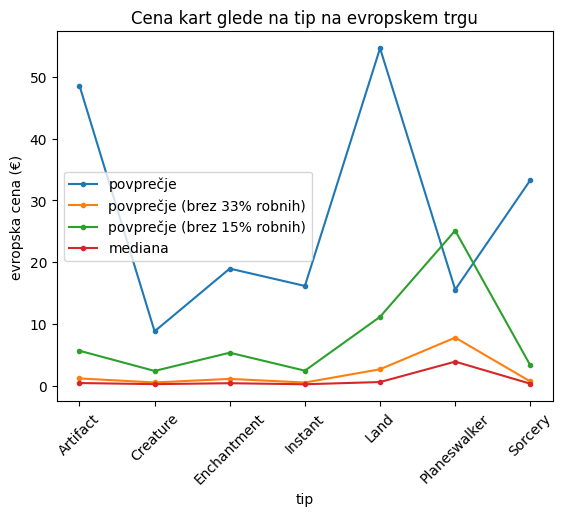

In [9]:
tabela_povprecnih_cen_eu = podatkovna_baza[["id_karte", "povprecje_eu"]].merge(povezovalna_cardtype)
povprecna_cena_eu = tabela_povprecnih_cen_eu.groupby("cardtype")["povprecje_eu"].mean()[dovolj_veliki_kljuci_cardtypov]
povprecna_cena_eu_67 = tabela_povprecnih_cen_eu.groupby("cardtype").agg({'povprecje_eu': q67}).loc[dovolj_veliki_kljuci_cardtypov]["povprecje_eu"]
povprecna_cena_eu_85 = tabela_povprecnih_cen_eu.groupby("cardtype").agg({'povprecje_eu': q85}).loc[dovolj_veliki_kljuci_cardtypov]["povprecje_eu"]
mediana = tabela_povprecnih_cen_eu.groupby("cardtype")["povprecje_eu"].median()[dovolj_veliki_kljuci_cardtypov]

df = pd.DataFrame({'povprečje': povprecna_cena_eu,
                   'povprečje (brez 33% robnih)': povprecna_cena_eu_67,
                   'povprečje (brez 15% robnih)': povprecna_cena_eu_85,
                   'mediana': mediana}, index=dovolj_veliki_kljuci_cardtypov)

ax = df.plot(rot=45, title="Cena kart glede na tip na evropskem trgu", xlabel = "tip", style='.-')
ax.set_ylabel("evropska cena (€)")

## Analiza posameznih setov glede na datum izida

Zanimalo me je, kateri seti so bili najbolj in kateri najmanj vredni, ter kakšna je korelacija med starostjo seta ter številom kart in njegovo vrednostjo.

Pri tem je sem gledal porvprečno vrednost kart v setu, saj je ta neodvisna njihovega števila. Povsem po pričakovanju sta na vrhu seta alfa (**LEA = Limited Edition Alpha**) in beta (**LEB = Limited Edition Beta**). 

In [10]:
grupa_setov = podatkovna_baza.groupby("set")
grupa_setov['povprecna_cena'].mean().sort_values(ascending=False).head(10)

set
LEA     2022.230601
LEB      913.761745
PSUM     794.680426
2ED      396.113984
ARN      271.257582
CED      110.726471
CEI       94.022894
PTK       91.854121
LEG       91.066000
ATQ       89.785200
Name: povprecna_cena, dtype: float64

Spodnji graf prikazuje povprečno ceno in število kart v setih glede na datum izida. Očitno je, da so seti zelo podobnih vrednosti, z izjemo nekaterih starejših, ki so veliko vrednješi. Omenil bi še, da so podatki za [odstopajoči set](https://scryfall.com/sets/psum), ki je izšel leta 2007, povsem napačno navedeni na strani *MTGStocks* (v resnici sta v setu samo dve karti, ki staneta v povprečju okoli kot 5$).

Mimogrede: na x-osi sem izpisal vsak 30. datum seta. Odtod lahko sklepamo, da se je frekvenca izidov setov močno povišala v zadnjih letih.

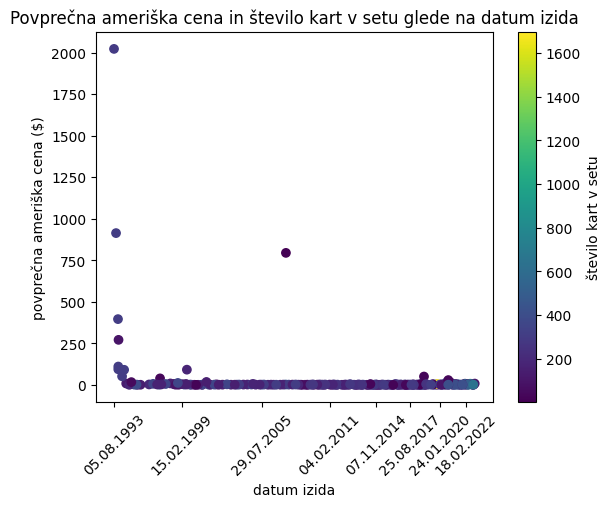

In [11]:
plot_data = grupa_setov[['datum_izida', 'povprecna_cena', 'st_kart']].mean()
plot_data = plot_data[~plot_data['datum_izida'].isna()]

plt.scatter(plot_data['datum_izida'], plot_data['povprecna_cena'], c=plot_data['st_kart'])
plt.xlabel('datum izida')
plt.ylabel('povprečna ameriška cena ($)')
plt.title('Povprečna ameriška cena in število kart v setu glede na datum izida')
plt.colorbar(orientation="vertical", label="število kart v setu")
plt.xticks(rotation=45)
plt.xticks(plot_data['datum_izida'].sort_values()[::30] , [datetime.fromtimestamp(x / 1000).strftime("%d.%m.%Y") for x in plot_data['datum_izida'].sort_values()][::30])
plt.show()

Seveda na zgornjem grafu ne moremo natančno videti trendov za novejše sete, zato raje uporabimo *logaritmično skalo*. 

Iz odtenka točk se lepo vidi, da je dandanes v setih več kart, kot jih je bilo včasih. Poleg tega je opazno, da so novejši seti vrednejši od setov med 2000-2015. To je najverjetneje zato, ker so novejše karte bolj relevantne od starejših in zato dražje (hkrati pa niso dovolj relevantne, da bi presegle zbirateljsko vrednost najstarejših).

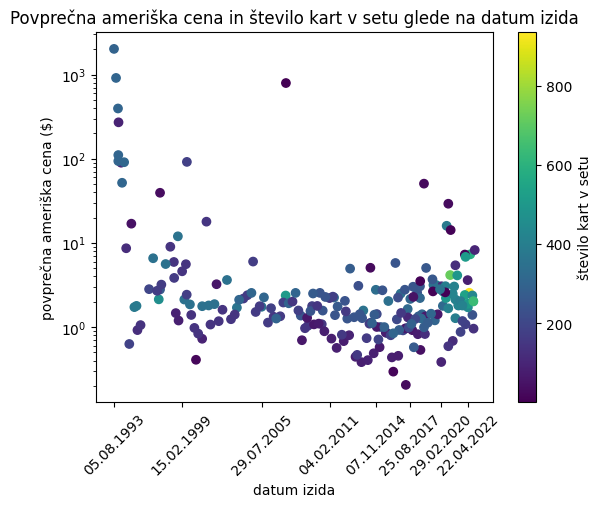

In [12]:
plot_data = grupa_setov[['datum_izida', 'povprecna_cena', 'st_kart']].mean()
plot_data = plot_data[~plot_data['datum_izida'].isna() & (plot_data['st_kart'] < 1000)]

plt.scatter(plot_data['datum_izida'], plot_data['povprecna_cena'], c=plot_data['st_kart'])
plt.xlabel('datum izida')
plt.ylabel('povprečna ameriška cena ($)')
plt.title('Povprečna ameriška cena in število kart v setu glede na datum izida')
plt.colorbar(orientation="vertical", label="število kart v setu")
plt.xticks(rotation=45)
plt.xticks(plot_data['datum_izida'].sort_values()[::30] , [datetime.fromtimestamp(x / 1000).strftime("%d.%m.%Y") for x in plot_data['datum_izida'].sort_values()][::30])
plt.yscale('log')
plt.show()

Poglejmo si še isti graf za evropski trg. Zanimvo je, da sta si grafa v logaritmični skali res zelo podobna.

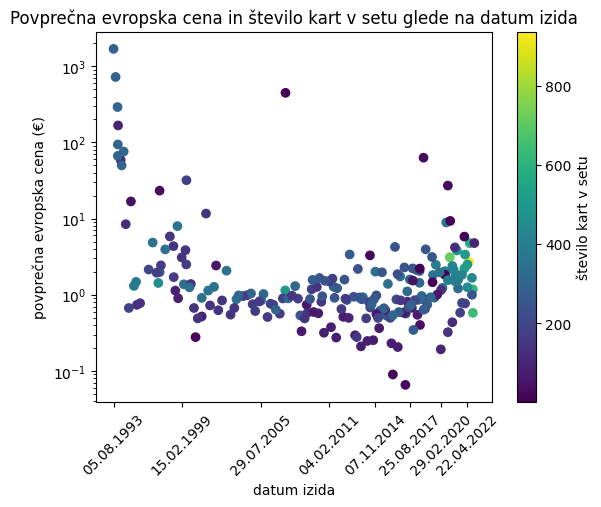

In [13]:
plot_data = grupa_setov[['datum_izida', 'povprecje_eu', 'st_kart']].mean()
plot_data = plot_data[~plot_data['datum_izida'].isna() & (plot_data['st_kart'] < 1000)]

plt.scatter(plot_data['datum_izida'], plot_data['povprecje_eu'], c=plot_data['st_kart'])
plt.xlabel('datum izida')
plt.ylabel('povprečna evropska cena (€)')
plt.title('Povprečna evropska cena in število kart v setu glede na datum izida')
plt.colorbar(orientation="vertical", label="število kart v setu")
plt.xticks(rotation=45)
plt.xticks(plot_data['datum_izida'].sort_values()[::30] , [datetime.fromtimestamp(x / 1000).strftime("%d.%m.%Y") for x in plot_data['datum_izida'].sort_values()][::30])
plt.yscale('log')
plt.show()

Zdaj si poglejmo, kdaj karte dosežejo svoj cenovni minimum in maksimum, merjeno od izida.

Text(0, 0.5, 'število tednov')

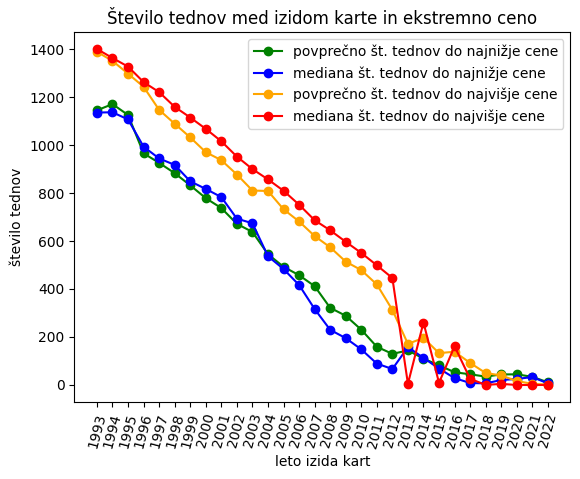

In [14]:
def izrazi_v_tednih(t):
    return t / 620000000

baza_datumov = podatkovna_baza[['datum_izida', 'all_time_low_datum', 'all_time_high_datum']].copy(deep=True)
baza_datumov = baza_datumov[~baza_datumov['datum_izida'].isna()]
baza_datumov["razlika_low"] = baza_datumov["all_time_low_datum"] - baza_datumov["datum_izida"]
baza_datumov["razlika_high"] = baza_datumov["all_time_high_datum"] - baza_datumov["datum_izida"]
baza_datumov[["razlika_low", "razlika_high"]] = baza_datumov[["razlika_low", "razlika_high"]].applymap(izrazi_v_tednih)
baza_datumov["datum_izida"] = baza_datumov["datum_izida"].apply(lambda x: datetime.fromtimestamp(x / 1000).strftime("%d.%m.%Y"))

plot_data = baza_datumov[['datum_izida', 'razlika_low', 'razlika_high']]

grupa_setov_po_letih = plot_data.groupby(plot_data["datum_izida"].map(lambda x: x[-4:]))

x = grupa_setov_po_letih["razlika_low"].median().index
y1 = grupa_setov_po_letih["razlika_low"].mean()
y2 = grupa_setov_po_letih["razlika_low"].median()
y3 = grupa_setov_po_letih["razlika_high"].mean()
y4 = grupa_setov_po_letih["razlika_high"].median()

plt.plot(x, y1, "-o", label = 'povprečno št. tednov do najnižje cene', color='green')
plt.plot(x, y2, "-o",label = 'mediana št. tednov do najnižje cene', color='blue')
plt.plot(x, y3, "-o",label = 'povprečno št. tednov do najvišje cene', color='orange')
plt.plot(x, y4, "-o",label = 'mediana št. tednov do najvišje cene', color='red')
plt.xticks(rotation=75)
plt.legend()
plt.title('Število tednov med izidom karte in ekstremno ceno')
plt.xlabel('leto izida kart')
plt.ylabel('število tednov')

Prav nič presenetljivega ni dejstvo, imajo starejši seti zelo veliko povprečno razliko tednov med izidom in najvišjo ceno (ker vrednost mnogim kartam s časom narašča). Dosti bolj presenetljivo pa je to, da imajo tako visko povprečno razliko tednov med izidom in najnižjo ceno. Sklepam, da nekaterim kartam vrednost narašča, nekaterim pa pada. Tako imajo starejši seti kljub visoki vrednosti veliko kart z nizkimi vrednostmi, ki višajo povprečje in mediano.

Hkrati pa opazimo, so krivulje v zadnjih petih letih dosti bolj zgoščene. Zato si jih podrobneje oglejmo:

Text(0, 0.5, 'število tednov')

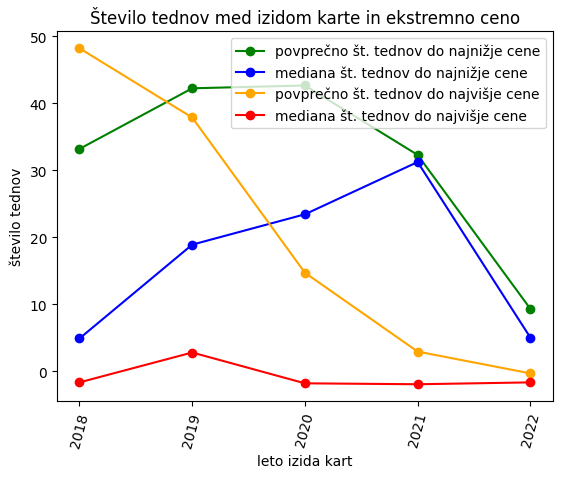

In [15]:
x = grupa_setov_po_letih["razlika_low"].median().index[-5:]
y1 = grupa_setov_po_letih["razlika_low"].mean()[-5:]
y2 = grupa_setov_po_letih["razlika_low"].median()[-5:]
y3 = grupa_setov_po_letih["razlika_high"].mean()[-5:]
y4 = grupa_setov_po_letih["razlika_high"].median()[-5:]

plt.plot(x, y1, "-o", label = 'povprečno št. tednov do najnižje cene', color='green')
plt.plot(x, y2, "-o",label = 'mediana št. tednov do najnižje cene', color='blue')
plt.plot(x, y3, "-o",label = 'povprečno št. tednov do najvišje cene', color='orange')
plt.plot(x, y4, "-o",label = 'mediana št. tednov do najvišje cene', color='red')
plt.xticks(rotation=75)
plt.legend()
plt.title('Število tednov med izidom karte in ekstremno ceno')
plt.xlabel('leto izida kart')
plt.ylabel('število tednov')

Žal ta graf izgleda precej kaotično, zato se zdi nevarno vleči prehitre zaključke. Bi pa komentiral to, da sta rdeča in rumena krivulja pod ostalima. Možen razlog bi bil v tem, da ima večina kart najvišjo ceno direktno po izidu, takoj zatem pa jim vpade. Poleg tega se zdi smiselno sklepati, da novejše karte v povprečju dosežejo svoj cenovni minimum v manj kot letu dni od izida.

Mimogrede bi še omenil, da so karte naprodaj že pred uradnim izidom seta, zato so lahko vrednosti na zgornjem grafu negativne.

## Obravnava raziskovalnih vprašanj ter možne nadgradnje projekta

**Rezultati analize so sledeči:**

1. Povezava med redkostjo in ceno kart očitno obstaja, saj so redkosti *Rare*, *Mythic*, *Special* in *Player Awards* po vseh merilih občutno dražje od *Common* in *Uncommon*. Zanimivo pa je dejstvo, da so v povprečju *Rare* karte najdražje, kar je posledica zgodovine igre.
2. Povezava med starostjo in ceno kart obstaja, vendar se razlikuje od pričakovanj. Pričakoval sem, da bodo najstarejše karte najdražje, nisem pa si mislil, da bodo najcenejše karte izdane med leti 2000 in 2015.
3. Najvrednješi tipi kart so *Land*-i, *Planeswalker*-ji in *Artifact*-i.
4. Najvrednejši so starejši seti, še posebej *Limited Edition Alpha* in *Limited Edition Beta*. Najcenejši so seti med leti 2000 in 2015.
5. Težko je oceniti v kolikšnem času od izida karte v povprečju dosežejo najnižjo ceno. Je pa to v zadnjih letih manj kot leto dni.
6. Ameriški in evropski trg se razen v višjih ameriških cenah praktično ne razlikujeta, oziroma tega nisem zaznal v svoji analizi. Vse oblike grafov so praktično identične.
7. Naivni Bayesov klasifikator za določanje barve karte se seveda da napisati, kar sem storil v datoteki `NaivniBayesZaDolocanjeBarve.ipynb`.

**Možne nadgradnje projekta:**

- Lahko bi preveril, kakšen je vpliv [*Reserved Lista*](https://mtg.fandom.com/wiki/Reserved_List) na ceno kart
- Lahko bi natančenje preveril strukturo posameznih setov
- Lahko bi dodal kaj z minimanlnimi in maksimalnimi cenami
- Lahko bi napisal Bayesove klasifikatorje še za ugibanje tipov ali podtipov kart